In [1]:
#!/bin/bash
# https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data
# !kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri
# !unzip "./brain-tumor-classification-mri.zip"


In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor, Resize, Normalize, Compose, Grayscale
from torchvision.transforms import v2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pandas as pd
from aux import ImagesMRIDataset, split_for_cross_validation, get_training_testing_data, plot_data, get_data_distribution, split_traing_data

class EarlyStopping():
    def __init__(self, path : str, patience=5, threshold=1e-4):
        self.patience = patience
        self.threshold = threshold
        self.min_loss = 10000
        self.steps_till_stop = 0
        self.path = path

    def continue_training(self, model, loss):
        if(loss < self.min_loss - self.threshold):
            self.min_loss = loss
            self.steps_till_stop = 0
            torch.save(model.state_dict(), self.path)
            return True
        if (loss >= self.min_loss - self.threshold):
            self.steps_till_stop += 1
            if (self.steps_till_stop == self.patience): return False
        return True
    
    def load_model(self, model):
        model.load_state_dict(torch.load(self.path, weights_only=True))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model


In [2]:
SIZE = (100, 100)
train_transform = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),  
    A.RandomGamma(gamma_limit=(80, 120), p=1.0), 
    A.HorizontalFlip(p = 0.5),
    A.ShiftScaleRotate(p = 0.5),
    A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), p=1.0), 
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

test_transformations = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def compute_train_transformations(image):
    image = train_transform(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)
    
def compute_test_transformations(image):
    image = test_transformations(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)


/home/alf/anul4/InvatareSupervizataTema2/venv/lib/python3.12/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
def training_loop(model, criterion, optimizer, dataloader : DataLoader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  current_training_loss = 0
  all_train_labels, all_train_preds = [], []
  model.train()
  for idx, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.to(device)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_training_loss += loss.item()
    all_train_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())
  return 2 * current_training_loss / len(dataloader),  all_train_preds, all_train_labels


def validation_loop(model, criterion, dataloader : DataLoader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_val_labels, all_val_preds = [], [],
    current_validation_loss = 0
    model.eval()
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        output = output.to(device)
        loss = criterion(output, labels)
        current_validation_loss += loss.item()
        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(output.argmax(dim=1).cpu().numpy())
    return 2 * current_validation_loss / len(dataloader),  all_val_preds, all_val_labels

def train_model(model, epochs, data, criterion, optimizer, lr_scheduler, early_stopping : EarlyStopping):
  training_loss = [] 
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []
  maxim_accuracy = -1
  for i in range(epochs):
      Tloss, train_pred, train_labels = training_loop(model, criterion, optimizer, data["train"])
      Vloss, all_val_preds, all_val_labels = validation_loop(model, criterion, data["validation"])
      if (early_stopping != None and not early_stopping.continue_training(model, Vloss)):
         print("Loss-ul nu a scazut de ceva vreme, a intervenit early stopping")
         break
      if (lr_scheduler != None):
        lr_scheduler.step(Vloss)
      training_loss.append(round(Tloss, 3))
      validation_loss.append(round(Vloss, 3))
      training_accuracy.append(round(accuracy_score(train_pred, train_labels), 3))
      validation_accuracy.append(round(accuracy_score(all_val_labels, all_val_preds), 3))
      if (maxim_accuracy < validation_accuracy[-1]):
        print(f"best model found at {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
        maxim_accuracy = validation_accuracy[-1]
      else:
         print(f"epoca {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
  return training_loss, validation_loss, training_accuracy, validation_accuracy

def test_model(model, dataloader, criterion):
    _, preds, labels = validation_loop(model, criterion, dataloader)
    precision = precision_score(preds, labels, average='macro') 
    recall = recall_score(preds, labels, average='macro')
    f1 = f1_score(preds, labels, average='macro')
    acc = accuracy_score(preds, labels)
    # auc = roc_auc_score(preds, labels,  multi_class="ovr", average="macro")
    return precision, recall, f1, acc, confusion_matrix(preds, labels)


In [ ]:
class Net(nn.Module):
    def __init__(self,  width : int, expansion : int):
        super().__init__()
        self.relu = nn.ReLU()
        self.width1 = width
        self.conv1 = nn.Conv2d(3, self.width1, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(self.width1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width2 = self.width1 * expansion
        self.conv2 = nn.Conv2d(self.width1, self.width2, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(self.width2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width3 = self.width2 * expansion
        self.conv3 = nn.Conv2d(self.width2, self.width3, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(self.width3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width4 = self.width3 * expansion
        self.conv4 = nn.Conv2d(self.width3, self.width4, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(self.width4)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width5 = self.width4 * expansion
        self.conv5 = nn.Conv2d(self.width4, self.width5, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(self.width5)

        # (1024, 12) -> (1024, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.width5, self.width4),
            nn.Dropout(p=0.5),
            nn.Linear(self.width4, self.width3),
            nn.Dropout(p=0.5),
            nn.Linear(self.width3, 4),
            # nn.Softmax(dim=1)
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x : torch.tensor):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu(self.bn3(self.conv3(x))))
        x = self.maxpool4(self.relu(self.bn4(self.conv4(x))))
        x = self.avgpool(self.relu(self.bn5(self.conv5(x))))
        return self. self.classification_layer(x)

model_try = Net(width=8, expansion=3)

for module in model_try.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")

Layer Type: Net(
  (relu): ReLU()
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 72, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode

In [5]:
grid_parameters = {
    "batch_size": [5, 10, 25, 50, 100],
    "epochs" : [50],
    "lr": [1e-1, 1e-2, 1e-3, 1e-4],
    "weight_decay": [1e-3, 1e-4],
    "optimizer_patience" : [3, 4, 5],
    "lr_factor": [0.1, 0.3, 0.5, 0.7],
    "width": [8, 16],
    "expansion" : [2, 3, 4],
    "early_stopping_patience" : [10],
}

def display_results_training(dataframe : pd.DataFrame):
    print(dataframe.head())
    for column in dataframe.columns:
        print(dataframe[column].mean(), end=" ")
    print()
    for column in dataframe.columns:
        print(dataframe[column].std(), end=" ")
    print()


def show_plot(list1, list2, label1, label2, title):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(list1) + 1), y=list1, label=label1, marker='o')
    sns.lineplot(x=range(1, len(list2) + 1), y=list2, label=label2, marker='o')
    plt.xlabel(label1)   
    plt.ylabel(label2)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_matrix(matrix):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1, 2, 3])
    cm_display.plot()
    plt.tight_layout()
    plt.show()
    
def add_info(info_data, precision, acc, recall, f1):
    info_data["precision"].append(precision)
    info_data["accuracy"].append(acc)
    info_data["recall"].append(recall)
    info_data["f1Score"].append(f1)
    return info_data


def create_cross_validation_data(data_chunks, test_data, current : int, train_transform, test_transform, batch_size):
    training_data = []
    for idx, chunk in enumerate(data_chunks):
        if (idx == current):
            continue
        training_data += chunk
    return {
        "train": DataLoader(ImagesMRIDataset(training_data, transformations=train_transform), batch_size=batch_size, shuffle=True, drop_last=True),
        "validation": DataLoader(ImagesMRIDataset(data_chunks[current], transformations=test_transform), batch_size=batch_size, shuffle=True),
        "test": DataLoader(ImagesMRIDataset(test_data, transformations=test_transform), batch_size=batch_size, shuffle=True)
    }

def compute_cross_validation(parameters, K, data_chunks, test_info, train_transforms, test_transforms, compute_functions):
    validation_info = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []} 
    info_test = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
    for i in range(K):
        model = Net(width=parameters["width"], expansion=parameters["expansion"])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        criterion, optimizer, lr_scheduler, early_stopping = compute_functions(model, parameters)
        data = create_cross_validation_data(data_chunks, test_info, i, train_transforms, test_transforms, parameters["epochs"])
        training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, parameters["epochs"],
            data, criterion, optimizer, lr_scheduler, early_stopping)
        show_plot(training_loss, validation_loss, "Train Loss", "Validation Loss", f"Loss model{i}")
        show_plot(training_accuracy, validation_accuracy, "Train Accuracy", "Validation Accuracy", f"Accuracy model{i}")
        if (early_stopping != None):
            best_model = Net(width=parameters["width"], expansion=parameters["expansion"])
            early_stopping.load_model(best_model)
        else:
            best_model = model
        precision, recall, f1, acc, mat = test_model(best_model, data["validation"], criterion)
        validation_info = add_info(validation_info, precision, acc, recall, f1)
        precision, recall, f1, acc, mat = test_model(best_model, data["test"], criterion)
        info_test = add_info(info_test, precision, acc, recall, f1)
    return pd.DataFrame.from_dict(info_test, "columns"), pd.DataFrame.from_dict(validation_info, "columns")

In [ ]:
from collections import Counter

current_parameters = {
    "batch_size": 50,
    "epochs" : 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "optimizer_patience" : 3,
    "lr_factor": 0.6,
    "width": 16,
    "expansion" : 4,
    "early_stopping_patience" : 7,
}
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

training_no_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE)
])

def compute_class_weights(data_stream):
    labels = [label for _, label in data_stream]
    label_counts = Counter(labels)
    total_samples = sum(label_counts.values())
    class_weights = {label: total_samples / count for label, count in label_counts.items()}
    max_label = max(label_counts.keys())
    weights_list = [class_weights.get(i, 0.0) for i in range(max_label + 1)]
    weights = torch.tensor(weights_list, dtype=torch.float)
    print(weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weights = weights.to(device)
    return weights 

def compute_functions_balanced_no_scheduler(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, None, None

 
# task 2 - fara augmentari, duplicarea exemplelor din clasele suplimentare
task2_no_augmentation_test, task2_no_augmentation_validation = compute_cross_validation(current_parameters, K, data_chunks, test_info, training_no_transforms, training_no_transforms, compute_functions_balanced_no_scheduler)
display_results_training(task2_no_augmentation_test)
display_results_training(task2_no_augmentation_validation)

In [ ]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

# task 2 - cu augmentari, cu duplicarea exemplelor din clasele suplimentare
task2_augmentation_test, task2_augmentation_validation = compute_cross_validation(current_parameters, K, data_chunks, test_info, compute_train_transformations, compute_test_transformations, compute_functions_balanced_no_scheduler)
display_results_training(task2_augmentation_test)
display_results_training(task2_augmentation_validation)

In [ ]:
K = 5
BALANCED = False
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

def compute_class_weights(data_stream):
    labels = [label for _, label in data_stream]
    label_counts = Counter(labels)
    total_samples = sum(label_counts.values())
    class_weights = {label: total_samples / count for label, count in label_counts.items()}
    max_label = max(label_counts.keys())
    weights_list = [class_weights.get(i, 0.0) for i in range(max_label + 1)]
    weights = torch.tensor(weights_list, dtype=torch.float)
    print(weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weights = weights.to(device)
    return weights 


def compute_functions_criterion_weighted(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(weight=compute_class_weights(training_info)), optimizer, None, None

# Task 2 cu augmentari - cu functia de loss avand weights
task2_augmentation_test_weighted, task2_augmentation_validation_weighted = compute_cross_validation(current_parameters, K, data_chunks, test_info, compute_train_transformations, compute_test_transformations, compute_functions_criterion_weighted)
display_results_training(task2_augmentation_test_weighted)
display_results_training(task2_augmentation_validation_weighted)

In [7]:
from monai.transforms import Resize, Rand2DElastic, RandAdjustContrast, RandRotate, ScaleIntensity, Compose
from monai.transforms import RandGaussianNoise, RandAffine, RandStdShiftIntensity
from monai.transforms import RandGaussianSmooth, ThresholdIntensity, RandAxisFlip
from monai.transforms import RandSpatialCrop, RandGaussianSharpen, RandHistogramShift, RandShiftIntensity
import cv2

first_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    RandGaussianSharpen(),
    RandAxisFlip(prob=0.3),
    RandSpatialCrop(roi_size=SIZE, random_center=True, random_size=False),
    RandRotate(range_x=(-50, 50),  prob=0.5, keep_size=True),
    RandAdjustContrast(prob=0.8),
    ScaleIntensity(minv=0.0, maxv=1.0)
])

second_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    Rand2DElastic(spacing=(5, 10), magnitude_range=(1, 2), prob=0.5, rotate_range=(0, 0), shear_range=(0.02, 0.02),
                    translate_range=(10, 10), scale_range=(0.1, 0.1), spatial_size=SIZE, mode="bilinear", padding_mode="reflection"),
    RandHistogramShift(prob=0.8),
    ThresholdIntensity(threshold=20),
    RandGaussianSmooth(sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5), prob=0.8),
    RandRotate(range_x=(-50, 50),  prob=0.5, keep_size=True),
    ScaleIntensity(minv=0.0, maxv=1.0)
])


third_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    RandGaussianNoise(mean=0.0, std=0.1, prob=0.8),
    RandShiftIntensity(offsets=(-20, 20), prob=0.3, safe=True),
    RandAxisFlip(prob=0.3),
    RandStdShiftIntensity(factors=0.8),
    RandAffine(prob=0.2),
    ScaleIntensity(minv=0.0, maxv=1.0)
])

test_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    ScaleIntensity(minv=0.0, maxv=1.0)
])

def create_test_monai(img):
    img = np.transpose(img, (2, 0, 1))
    return test_augmentation_pipeline(img)

def create_first_monai_transform(img):
    img = np.transpose(img, (2, 0, 1))
    return first_augmentation_pipeline(img)


def create_second_monai_transform(img):
    img = np.transpose(img, (2, 0, 1))
    return second_augmentation_pipeline(img)


def create_third_monai_transform(img):
    img = np.transpose(img, (2, 0, 1))
    return third_augmentation_pipeline(img)

# img = torch.randint(low=0, high=255, size=(3, 400, 400))
# img = first_augmentation_pipeline(img)
# print(img.shape)

/home/alf/anul4/InvatareSupervizataTema2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)
task3_first_monai_test, task3_first_monai_validation = compute_cross_validation(current_parameters, K, data_chunks, test_info, create_first_monai_transform, create_test_monai, compute_functions_balanced_no_scheduler)
display_results_training(task3_first_monai_test)
display_results_training(task3_first_monai_validation)

In [ ]:
task3_second_monai_test, task3_second_monai_validation = compute_cross_validation(current_parameters, K, data_chunks, test_info, create_second_monai_transform, create_test_monai, compute_functions_balanced_no_scheduler)
display_results_training(task3_second_monai_test)
display_results_training(task3_second_monai_validation)

In [ ]:
task3_third_monai_test, task3_third_monai_validation = compute_cross_validation(current_parameters, K, data_chunks, test_info, create_third_monai_transform, create_test_monai, compute_functions_balanced_no_scheduler)
display_results_training(task3_third_monai_test)
display_results_training(task3_third_monai_validation)

In [8]:
def compute_functions_with_early_stopper(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, None, EarlyStopping("./aici.pth", parameters['early_stopping_patience'])

def compute_functions_simple(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=parameters["optimizer_patience"], factor=parameters["lr_factor"]), EarlyStopping("./aici.pth", parameters['early_stopping_patience'])




In [ ]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)
current_parameters = {
    "batch_size": 50,
    "epochs" : 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "optimizer_patience" : 3,
    "lr_factor": 0.6,
    "width": 16,
    "expansion" : 4,
    "early_stopping_patience" : 7,
}

task4_ealry_stopping_test, task4_ealry_stopping_validation = compute_cross_validation(current_parameters, K, data_chunks, test_info, create_third_monai_transform, create_test_monai, compute_functions_with_early_stopper)
display_results_training(task4_ealry_stopping_test)
display_results_training(task4_ealry_stopping_validation)

best model found at 0 loss is 1.887 accuracy is 0.655
best model found at 1 loss is 1.959 accuracy is 0.691
best model found at 2 loss is 1.302 accuracy is 0.732
best model found at 3 loss is 0.788 accuracy is 0.868
epoca 4 loss is 2.304 accuracy is 0.704
epoca 5 loss is 0.866 accuracy is 0.83
best model found at 6 loss is 0.538 accuracy is 0.908
epoca 7 loss is 1.067 accuracy is 0.836
epoca 8 loss is 1.953 accuracy is 0.655
epoca 9 loss is 0.812 accuracy is 0.896
epoca 10 loss is 1.626 accuracy is 0.772
best model found at 11 loss is 0.588 accuracy is 0.919
best model found at 12 loss is 0.521 accuracy is 0.945
best model found at 13 loss is 0.334 accuracy is 0.951
epoca 14 loss is 0.389 accuracy is 0.945
epoca 15 loss is 0.888 accuracy is 0.891
epoca 16 loss is 0.407 accuracy is 0.947
epoca 17 loss is 0.544 accuracy is 0.915
best model found at 18 loss is 0.312 accuracy is 0.955
epoca 19 loss is 0.657 accuracy is 0.908
epoca 20 loss is 0.395 accuracy is 0.947
best model found at 21 l

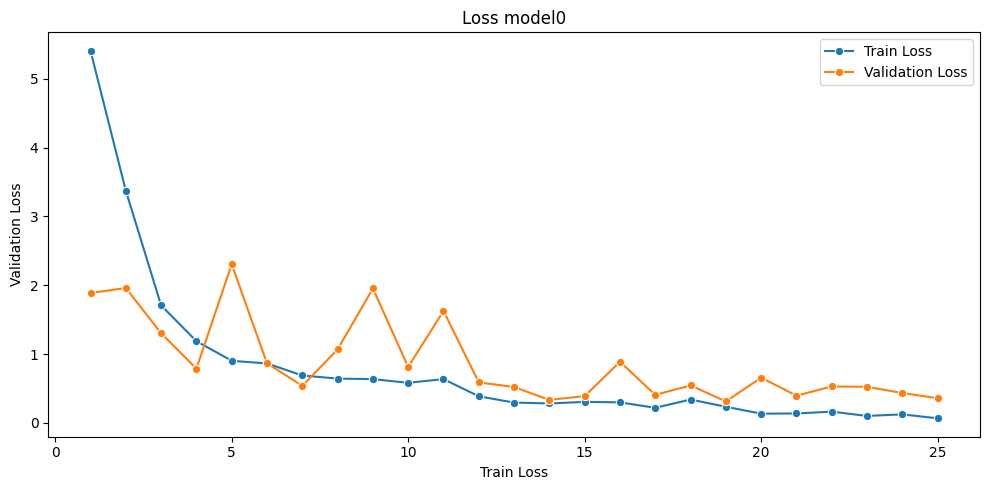

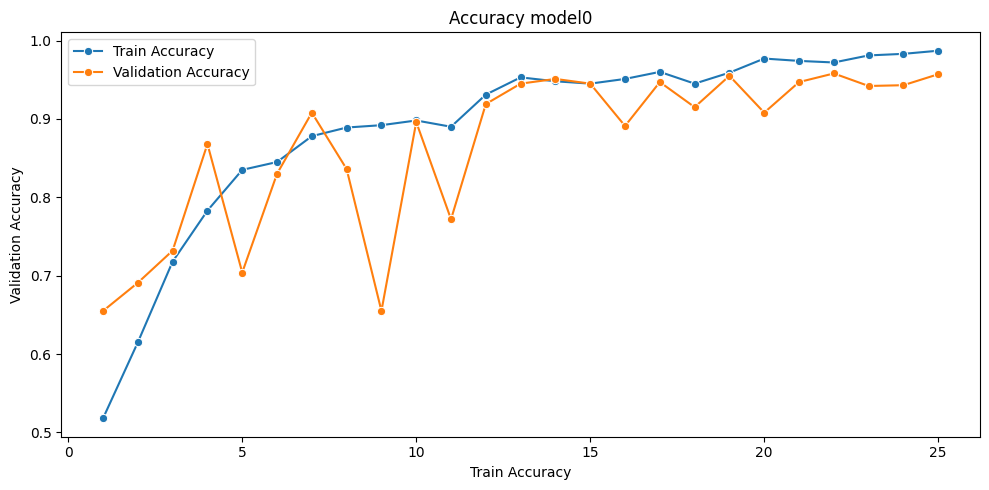

best model found at 0 loss is 3.976 accuracy is 0.519
best model found at 1 loss is 2.461 accuracy is 0.617
best model found at 2 loss is 2.112 accuracy is 0.652
best model found at 3 loss is 0.917 accuracy is 0.818
best model found at 4 loss is 0.923 accuracy is 0.831
epoca 5 loss is 1.74 accuracy is 0.725
best model found at 6 loss is 0.815 accuracy is 0.85
epoca 7 loss is 1.181 accuracy is 0.831
best model found at 8 loss is 1.08 accuracy is 0.856
epoca 9 loss is 1.319 accuracy is 0.763
epoca 10 loss is 0.864 accuracy is 0.847
epoca 11 loss is 2.638 accuracy is 0.752
best model found at 12 loss is 0.404 accuracy is 0.924
best model found at 13 loss is 0.474 accuracy is 0.926
epoca 14 loss is 0.665 accuracy is 0.875
epoca 15 loss is 1.715 accuracy is 0.814
epoca 16 loss is 1.309 accuracy is 0.816
best model found at 17 loss is 0.477 accuracy is 0.934
epoca 18 loss is 0.441 accuracy is 0.934
epoca 19 loss is 0.455 accuracy is 0.934
epoca 20 loss is 0.603 accuracy is 0.926
best model f

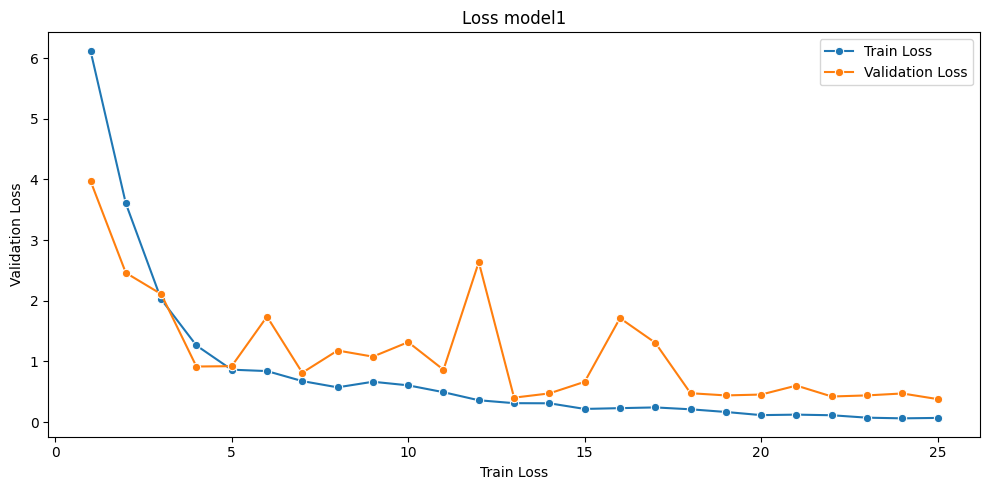

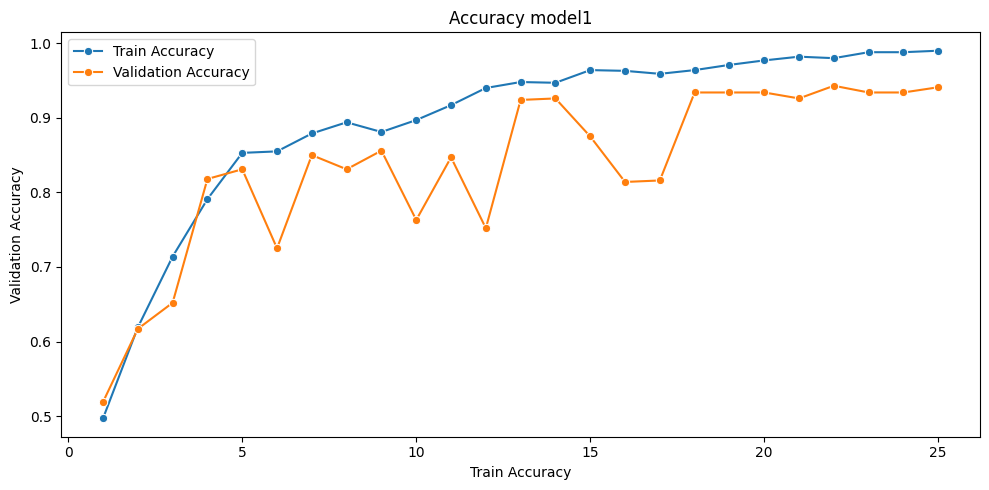

best model found at 0 loss is 2.45 accuracy is 0.603
best model found at 1 loss is 1.417 accuracy is 0.74
best model found at 2 loss is 1.281 accuracy is 0.744
best model found at 3 loss is 0.787 accuracy is 0.86
epoca 4 loss is 0.955 accuracy is 0.831
epoca 5 loss is 2.059 accuracy is 0.679
epoca 6 loss is 2.504 accuracy is 0.713
epoca 7 loss is 1.388 accuracy is 0.767
best model found at 8 loss is 0.713 accuracy is 0.873
best model found at 9 loss is 0.593 accuracy is 0.882
epoca 10 loss is 1.851 accuracy is 0.753
epoca 11 loss is 1.542 accuracy is 0.81
best model found at 12 loss is 0.592 accuracy is 0.907
epoca 13 loss is 1.113 accuracy is 0.861
best model found at 14 loss is 0.641 accuracy is 0.913
epoca 15 loss is 1.311 accuracy is 0.835
epoca 16 loss is 0.613 accuracy is 0.898
best model found at 17 loss is 0.361 accuracy is 0.939
epoca 18 loss is 0.446 accuracy is 0.924
epoca 19 loss is 1.456 accuracy is 0.839
epoca 20 loss is 0.745 accuracy is 0.907
epoca 21 loss is 0.736 accu

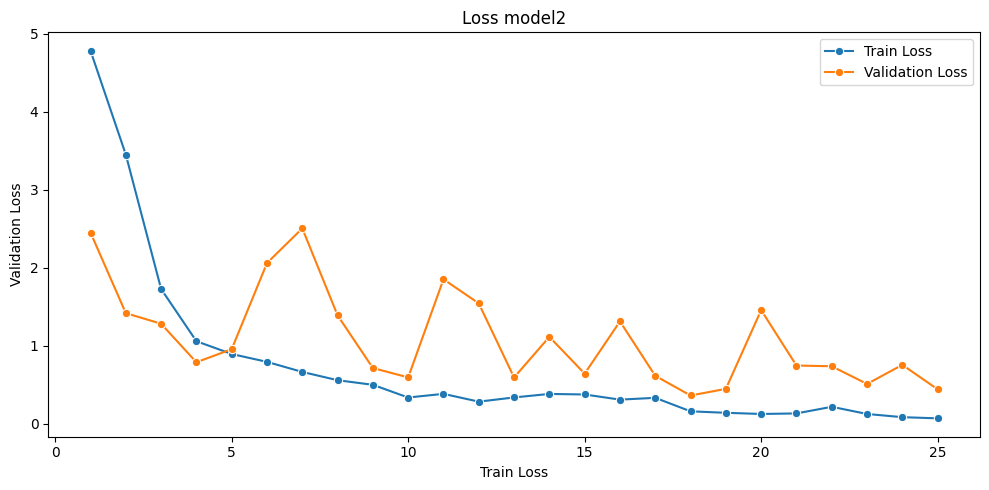

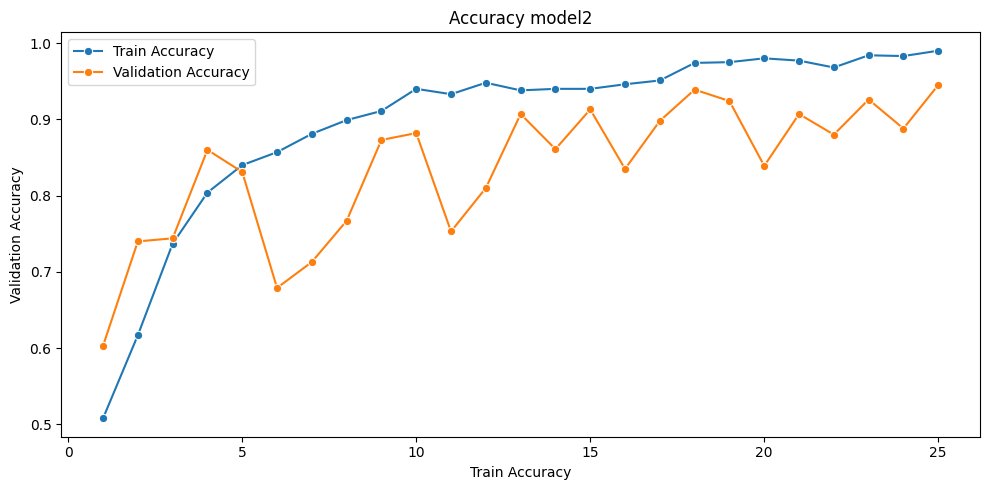

best model found at 0 loss is 3.59 accuracy is 0.488
best model found at 1 loss is 1.833 accuracy is 0.706
best model found at 2 loss is 1.03 accuracy is 0.814
best model found at 3 loss is 0.572 accuracy is 0.886
epoca 4 loss is 2.81 accuracy is 0.528
epoca 5 loss is 0.599 accuracy is 0.884
epoca 6 loss is 6.176 accuracy is 0.545
epoca 7 loss is 0.839 accuracy is 0.858
epoca 8 loss is 0.731 accuracy is 0.886
epoca 9 loss is 0.942 accuracy is 0.843
epoca 10 loss is 0.787 accuracy is 0.869
best model found at 11 loss is 0.375 accuracy is 0.924
best model found at 12 loss is 0.315 accuracy is 0.947
epoca 13 loss is 0.929 accuracy is 0.869
epoca 14 loss is 0.406 accuracy is 0.935
epoca 15 loss is 1.245 accuracy is 0.827
epoca 16 loss is 1.377 accuracy is 0.803
best model found at 17 loss is 0.253 accuracy is 0.964
epoca 18 loss is 0.226 accuracy is 0.953
epoca 19 loss is 0.379 accuracy is 0.928
epoca 20 loss is 0.272 accuracy is 0.956
epoca 21 loss is 0.34 accuracy is 0.953
epoca 22 loss 

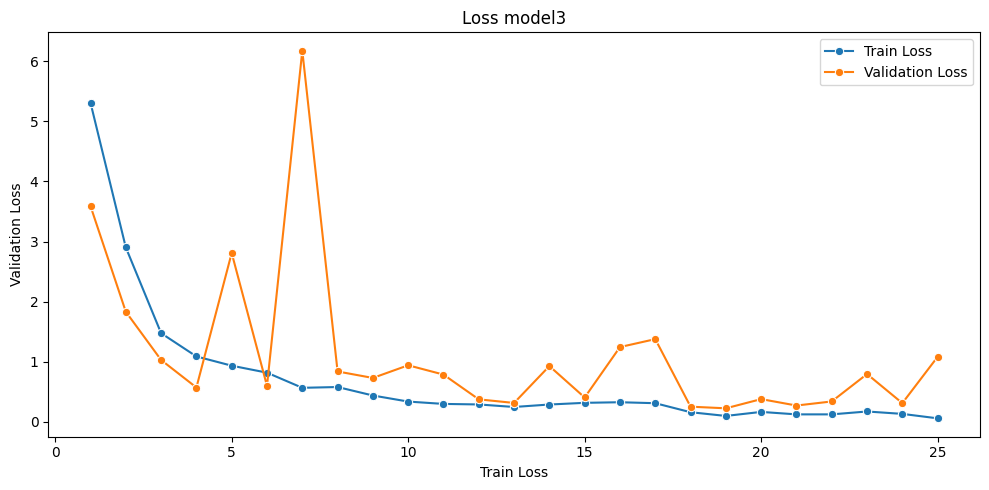

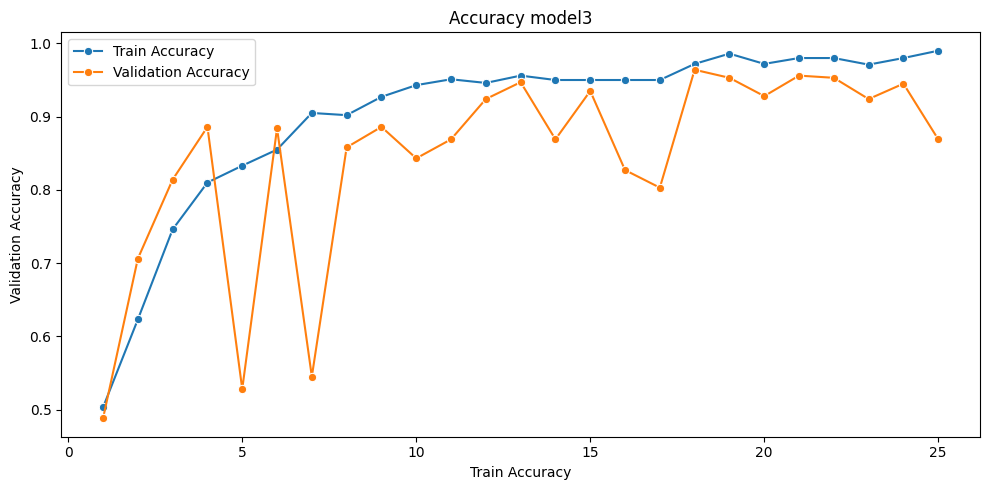

best model found at 0 loss is 6.793 accuracy is 0.368
best model found at 1 loss is 2.688 accuracy is 0.619
best model found at 2 loss is 1.398 accuracy is 0.765
best model found at 3 loss is 0.879 accuracy is 0.848
epoca 4 loss is 0.968 accuracy is 0.812
best model found at 5 loss is 0.697 accuracy is 0.886
epoca 6 loss is 1.244 accuracy is 0.831
epoca 7 loss is 0.965 accuracy is 0.848
epoca 8 loss is 2.086 accuracy is 0.7
epoca 9 loss is 1.154 accuracy is 0.824
epoca 10 loss is 0.812 accuracy is 0.879
best model found at 11 loss is 0.563 accuracy is 0.922
best model found at 12 loss is 0.483 accuracy is 0.924
epoca 13 loss is 0.864 accuracy is 0.879
epoca 14 loss is 0.576 accuracy is 0.909
epoca 15 loss is 0.568 accuracy is 0.907
best model found at 16 loss is 0.311 accuracy is 0.953
epoca 17 loss is 0.581 accuracy is 0.903
epoca 18 loss is 0.539 accuracy is 0.917
epoca 19 loss is 0.431 accuracy is 0.937
epoca 20 loss is 0.471 accuracy is 0.932
epoca 21 loss is 0.552 accuracy is 0.91

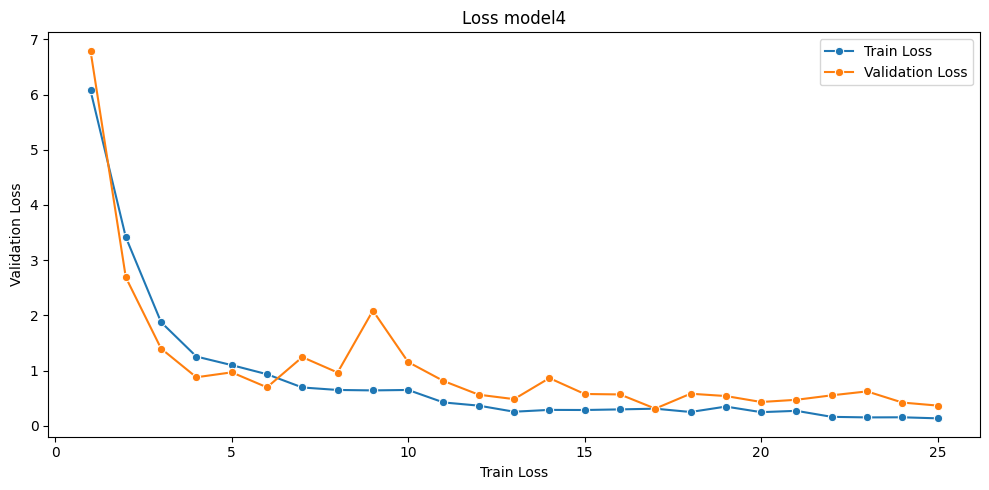

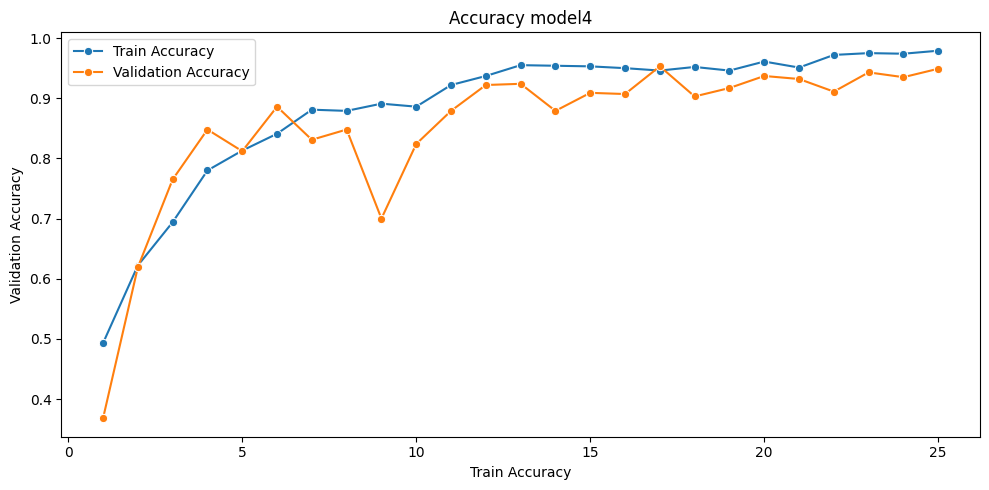

   precision    recall   f1Score  accuracy
0   0.732462  0.793032  0.714927  0.741117
1   0.703594  0.803543  0.681021  0.718274
2   0.738555  0.813836  0.709513  0.746193
3   0.728963  0.757675  0.720765  0.733503
4   0.727660  0.819427  0.706252  0.738579
0.7262468244642158 0.7975027645138683 0.7064958693809789 0.7355329949238578 
0.013347461264957313 0.02444484048033142 0.015271061531278246 0.010678012166478503 
   precision    recall   f1Score  accuracy
0   0.956496  0.956696  0.956387  0.956604
1   0.941288  0.941721  0.941189  0.941288
2   0.944888  0.945210  0.944582  0.944972
3   0.868523  0.905371  0.865911  0.869070
4   0.948762  0.949465  0.948655  0.948767
0.9319914985242427 0.9396923193356489 0.9313449106260585 0.932140000303779 
0.0359260976430672 0.019982248377908234 0.03701515479952533 0.03571082034311146 


In [ ]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)
current_parameters = {
    "batch_size": 50,
    "epochs" : 25,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "optimizer_patience" : 3,
    "lr_factor": 0.6,
    "width": 16,
    "expansion" : 4,
    "early_stopping_patience" : 7,
}

def compute_functions_with_lr_scheduler(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=parameters["optimizer_patience"], factor=parameters["lr_factor"]), None


task4_lr_scheduler_test, task4_lr_scheduler_validation = compute_cross_validation(current_parameters, K, data_chunks, test_info, create_first_monai_transform, create_test_monai, compute_functions_with_lr_scheduler)
display_results_training(task4_lr_scheduler_test)
display_results_training(task4_lr_scheduler_validation)

In [17]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)
parameters = {
    "batch_size": 16,
    "epochs" : 50,
    "lr": 1e-2,
    "weight_decay": 1e-4,
    "optimizer_patience" : 3,
    "lr_factor": 0.6,
    "width": 16,
    "expansion" : 4,
    "early_stopping_patience" : 7,
}

# 72 maxim
def compute_ablatiations(model : Net, parameters):
    # optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    optimizer = torch.optim.SGD(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"], momentum=0.7)
    return torch.nn.BCEWithLogitsLoss(), optimizer, torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=parameters["optimizer_patience"], factor=parameters["lr_factor"]), EarlyStopping("./aici.pth", patience=parameters["early_stopping_patience"])

SIZE=(100, 100)
ablatiation_augmentation = Compose([
    Resize(spatial_size= SIZE),
    RandGaussianSharpen(),
    RandAxisFlip(prob=0.3),
    RandSpatialCrop(roi_size=SIZE, random_center=True, random_size=False),
    RandRotate(range_x=(-50, 50),  prob=0.5, keep_size=True),
    RandAdjustContrast(prob=0.8),
    ScaleIntensity(minv=0.0, maxv=1.0)
])


def create_ablatiation_transform(img):
    img = np.transpose(img, (2, 0, 1))
    return ablatiation_augmentation(img)


test_augmentation_ablatiation = Compose([
    Resize(spatial_size= SIZE),
    ScaleIntensity(minv=0.0, maxv=1.0)
])

def create_ablatiation_test_monai(img):
    img = np.transpose(img, (2, 0, 1))
    return test_augmentation_ablatiation(img)


validation_info = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []} 
info_test = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
for i in range(K):
    if (i != 1):
        continue
    model = Net(width=parameters["width"], expansion=parameters["expansion"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion, optimizer, lr_scheduler, early_stopping = compute_ablatiations(model, parameters)
    data = create_cross_validation_data(data_chunks, test_info, i, create_ablatiation_transform, create_ablatiation_test_monai, parameters["epochs"])
    training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, parameters["epochs"],
            data, criterion, optimizer, lr_scheduler, early_stopping)
    show_plot(training_loss, validation_loss, "Train Loss", "Validation Loss", f"Loss model{i}")
    show_plot(training_accuracy, validation_accuracy, "Train Accuracy", "Validation Accuracy", f"Accuracy model{i}")
    if (early_stopping != None):
        best_model = Net(width=parameters["width"], expansion=parameters["expansion"])
        early_stopping.load_model(best_model)
    else:
        best_model = model
    precision, recall, f1, acc, mat = test_model(best_model, data["validation"], criterion)
    validation_info = add_info(validation_info, precision, acc, recall, f1)
    precision, recall, f1, acc, mat = test_model(best_model, data["test"], criterion)
    info_test = add_info(info_test, precision, acc, recall, f1)

display_results_training(pd.DataFrame.from_dict(info_test, "columns"))
display_results_training(pd.DataFrame.from_dict(validation_info, "columns"))

ValueError: Target size (torch.Size([50])) must be the same as input size (torch.Size([50, 1]))